In [1]:
# imports
import time
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import econml
import time
from econml.grf import CausalForest
# set numpy seed
np.random.seed(0)

from RATE import *

import pandas as pd
from ydata_profiling import ProfileReport

In [2]:
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import rpy2.robjects.numpy2ri
import rpy2.robjects.lib.tidyr
# Convert pandas.DataFrames to R dataframes automatically.
pandas2ri.activate()
rpy2.robjects.numpy2ri.activate()

grf = importr("grf")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/rpy2/robjects/lib/dplyr.py:27: UserWarning: This was designed against dplyr versions starting with 1.0 but you have 1.1.4
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/rpy2/robjects/lib/tidyr.py:12: UserWarning: This was designed against tidyr versions starting with 1.2. but you have 1.3.1
  warnings.warn(


## Read in data and prelim

In [3]:
df = pd.read_csv('earnings_dataset.csv')
# profile = ProfileReport(df, title="Profiling Report")
# profile.to_file("JTPA_earnings_report.html")

In [4]:
df["elder"] = df["age"].apply(lambda x: 1 if x>=40 else 0)
df_filtered = df.reset_index()[["elder", "age", "hsged", "white", "black", "hispanic", "native", "asian", "children", "married", "male", "treatment", "total_earn"]]

In [5]:
df_filtered = df_filtered[(df_filtered['hsged'] != 9) & (df_filtered['children'] != 9) & (df_filtered['married'] != 9)]
df_filtered = df_filtered.reset_index()
df_filtered = df_filtered.drop('index', axis=1)
df_filtered

,elder,age,hsged,white,black,hispanic,native,asian,children,married,male,treatment,total_earn
0,1,46,1,0,1,0,0,0,0,0,0,1,1353
1,0,24,1,1,0,0,0,0,1,0,0,1,4984
2,0,19,0,1,0,0,0,0,0,0,1,1,24141
3,0,34,1,0,0,1,0,0,1,1,0,1,27707
4,0,31,1,1,0,0,0,0,1,0,0,1,31860
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13193,0,34,0,1,0,0,0,0,1,0,1,1,45862
13194,0,35,1,1,0,0,0,0,1,0,0,1,4575
13195,0,29,0,1,0,0,0,0,0,0,1,1,55395
13196,0,27,1,1,0,0,0,0,1,1,0,1,4041


In [6]:
np.mean(df_filtered["elder"])

0.14259736323685407

In [7]:
np.mean(df_filtered["treatment"])

0.6691923018639188

In [8]:
df_final = df_filtered

In [9]:
X_full = df_final[["age", "hsged", "white", "black", "hispanic", "native", "asian", "children", "married", "male"]].values
W_full = df_final[["treatment"]].values
Y_full = df_final[["total_earn"]].values
A_full = df_final[["elder"]].values # imbalanced variable

In [10]:
df_train, df_test = train_test_split(df_final, test_size=0.5, random_state=42)
X_train = df_train[["age", "hsged", "white", "black", "hispanic", "native", "asian", "children", "married", "male"]].values
W_train = df_train[["treatment"]].values 
Y_train = df_train[["total_earn"]].values
A_train = df_train[["elder"]].values
X_test = df_test[["age", "hsged", "white", "black", "hispanic", "native", "asian","children", "married", "male"]].values
W_test = df_test[["treatment"]].values
Y_test = df_test[["total_earn"]].values
A_test = df_test[["elder"]].values

In [11]:
forest = grf.causal_forest(X_train, Y_train, W_train, W_hat = np.mean(W_train))

In [12]:
CATE_pred = grf.predict_causal_forest(forest, X_train)
CATE_pred = np.array(CATE_pred).flatten()
CATE_pred

array([ 3772.37939963,  2140.41320534, -3070.52143535, ...,
        2547.24988374,  -510.98001086,    10.17026707])

In [13]:
np.quantile(CATE_pred, np.linspace(0, 1, 5))

array([-5548.87900136,  -953.81959873,   596.60440606,  2091.21658555,
        7031.39363945])

In [14]:
def causalForest_estimator(X, W, Y, A, weight_minority=1.0, num_trees=2000):
    sample_weights = A.flatten() * (weight_minority-1.0) + 1.0
    model = grf.causal_forest(X, Y, W, W_hat = np.mean(W), num_trees=num_trees, sample_weights = sample_weights)
    return model

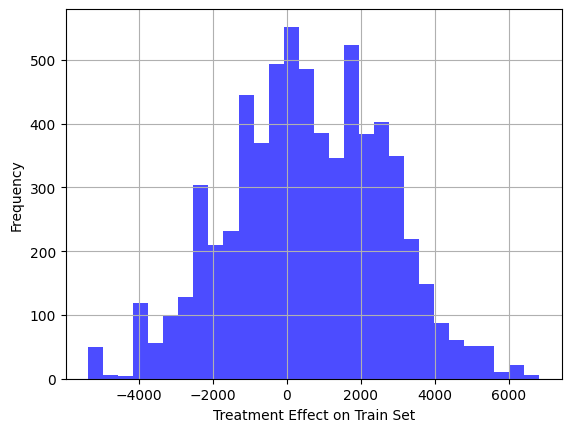

In [15]:
model = causalForest_estimator(X_train, W_train, Y_train, A_train)
CATE_pred = grf.predict_causal_forest(model, X_train)
CATE_pred = np.array(CATE_pred).flatten()
plt.hist(CATE_pred, bins=30, color='blue', alpha=0.7)
plt.xlabel('Treatment Effect on Train Set')
plt.ylabel('Frequency')
plt.grid(True)
%matplotlib inline
plt.show()

In [16]:
np.mean(CATE_pred), np.median(CATE_pred)

(555.3957793608301, 545.1067923007888)

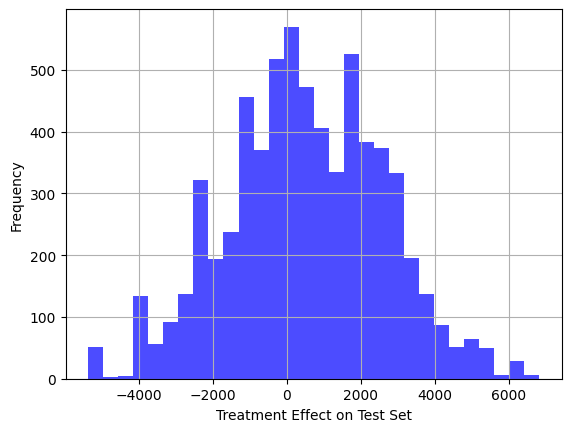

In [17]:
CATE_pred = grf.predict_causal_forest(model, X_test)
CATE_pred = np.array(CATE_pred).flatten()
plt.hist(CATE_pred, bins=30, color='blue', alpha=0.7)
plt.xlabel('Treatment Effect on Test Set')
plt.ylabel('Frequency')
plt.grid(True)
%matplotlib inline
plt.show()

In [18]:
np.quantile(CATE_pred, np.linspace(0, 1, 5))

array([-5365.81741374,  -927.69301939,   461.86203845,  2066.86099996,
        6816.17085155])

In [19]:
np.mean(CATE_pred), np.median(CATE_pred)

(508.68145321089713, 461.86203844827537)

In [20]:
model = causalForest_estimator(X_train, W_train, Y_train, A_train, weight_minority = 1.0)
CATE_pred = grf.predict_causal_forest(model, X_test)
CATE_pred = np.array(CATE_pred).flatten()

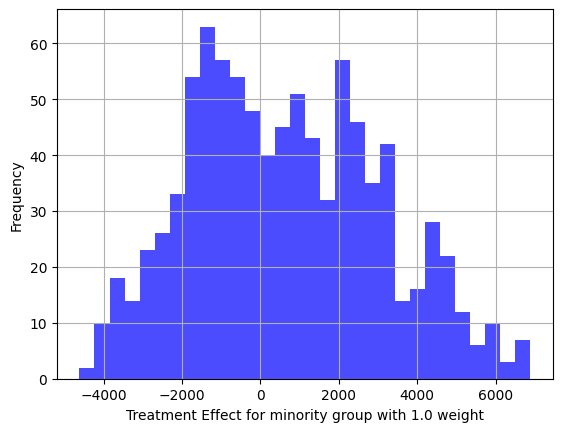

In [21]:
CATE_pred_min = CATE_pred[np.where(A_test[:,0] == 1)[0]]
plt.hist(CATE_pred_min, bins=30, color='blue', alpha=0.7)
plt.xlabel('Treatment Effect for minority group with 1.0 weight')
plt.ylabel('Frequency')
plt.grid(True)
%matplotlib inline
plt.show()

In [22]:
np.quantile(CATE_pred_min, np.linspace(0, 1, 5)) # treatment effect is roughly 0

array([-4618.38128375, -1283.28025679,   456.42931557,  2427.27127098,
        6885.31200245])

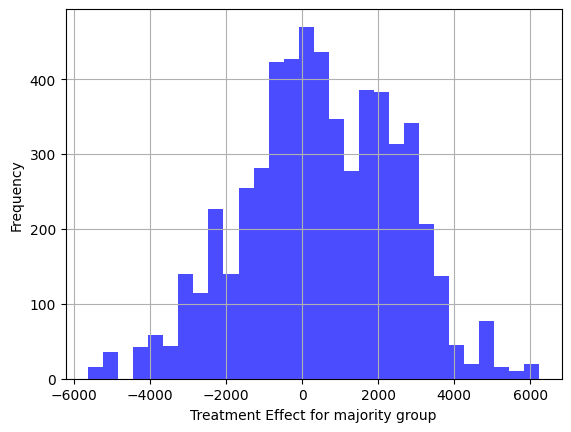

In [23]:
CATE_pred_maj = CATE_pred[np.where(A_test[:,0] == 0)[0]]
plt.hist(CATE_pred_maj, bins=30, color='blue', alpha=0.7)
plt.xlabel('Treatment Effect for majority group')
plt.ylabel('Frequency')
plt.grid(True)
%matplotlib inline
plt.show()

In [24]:
np.quantile(CATE_pred_maj, np.linspace(0, 1, 5)) # treatment effect is roughly 0

array([-5616.50166765,  -781.71755413,   508.13968821,  2004.47894589,
        6227.97856849])

## Fit a good regression forest to predict nuissance function

In [25]:
from econml.sklearn_extensions.model_selection import GridSearchCVList

cv_params_RF={
    'n_estimators':[100,200,300,400,500,600,700,800],
    'max_depth':[3,5,7,9],
    'min_samples_split':[4,6,8,10,12], # 10
    'min_samples_leaf':[3,5,7,9,11], # 5
    'min_impurity_decrease':[0.0001,0.001,0.01,0.05]
 }

start_time = time.time()
ind_params_RF={'n_jobs':-1,'random_state':42}
GSCV_RF=GridSearchCVList([econml.grf.RegressionForest(**ind_params_RF)],[cv_params_RF],cv=5,scoring='neg_root_mean_squared_error',n_jobs=-1)
GSCV_RF.fit(np.hstack([X_train, W_train]), Y_train)
print("--- %s seconds ---" % (time.time() - start_time))
# 12min? for 1024

--- 4933.503822088242 seconds ---


In [26]:
pd.DataFrame(GSCV_RF._gcv_list[0].cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_impurity_decrease,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.443868,0.061838,0.075304,0.009669,3,0.0001,3,4,100,"{'max_depth': 3, 'min_impurity_decrease': 0.00...",-15493.968155,-14733.962183,-15276.267767,-15276.176787,-15288.734072,-15213.821793,253.829362,2481
1,1.081941,0.024925,0.123102,0.008855,3,0.0001,3,4,200,"{'max_depth': 3, 'min_impurity_decrease': 0.00...",-15498.760408,-14730.791503,-15288.846649,-15279.528546,-15279.439858,-15215.473393,256.416253,2701
2,1.687419,0.083974,0.142101,0.008468,3,0.0001,3,4,300,"{'max_depth': 3, 'min_impurity_decrease': 0.00...",-15502.315386,-14727.375176,-15293.187486,-15286.155379,-15279.564796,-15217.719645,259.089213,3161
3,2.267894,0.059445,0.178110,0.004707,3,0.0001,3,4,400,"{'max_depth': 3, 'min_impurity_decrease': 0.00...",-15499.018131,-14724.575786,-15296.972477,-15284.760209,-15280.383629,-15217.142046,259.622903,3061
4,2.969570,0.084790,0.216141,0.004921,3,0.0001,3,4,500,"{'max_depth': 3, 'min_impurity_decrease': 0.00...",-15499.971679,-14726.939313,-15293.492564,-15283.442667,-15279.021847,-15216.573614,258.590019,2881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,4.980165,0.048006,0.216290,0.010289,9,0.05,11,12,400,"{'max_depth': 9, 'min_impurity_decrease': 0.05...",-15402.281457,-14674.843616,-15199.335002,-15182.371497,-15138.591943,-15119.484703,240.156451,221
3196,5.516399,0.343806,0.280714,0.018500,9,0.05,11,12,500,"{'max_depth': 9, 'min_impurity_decrease': 0.05...",-15405.120552,-14681.405103,-15196.237472,-15181.047249,-15142.550090,-15121.272093,238.200985,417
3197,5.975506,0.175115,0.372847,0.063117,9,0.05,11,12,600,"{'max_depth': 9, 'min_impurity_decrease': 0.05...",-15407.048721,-14684.683640,-15193.758033,-15176.608853,-15141.459325,-15120.711714,237.065426,337
3198,6.852712,0.156070,0.395612,0.023036,9,0.05,11,12,700,"{'max_depth': 9, 'min_impurity_decrease': 0.05...",-15406.731342,-14682.422891,-15191.968464,-15177.420548,-15138.079144,-15119.324478,237.692971,181


In [27]:
GSCV_RF.best_score_

-15116.605779091367

In [28]:
GSCV_RF.best_params_

{'max_depth': 9,
 'min_impurity_decrease': 0.01,
 'min_samples_leaf': 9,
 'min_samples_split': 4,
 'n_estimators': 800}

In [29]:
from econml.sklearn_extensions.model_selection import GridSearchCVList

cv_params_RF={
    'n_estimators':[100,200,300,400,500],
    'max_depth':[3,5,7,9],
    'min_samples_split':[7,10,13], # 10
    'min_samples_leaf':[3,5,7,9], # 5
    'min_impurity_decrease':[0,0.0001,0.001,0.01]
 }

start_time = time.time()
ind_params_RF={'n_jobs':-1,'random_state':42}
GSCV_RF=GridSearchCVList([econml.grf.RegressionForest(**ind_params_RF)],[cv_params_RF],cv=4,scoring='neg_root_mean_squared_error',n_jobs=-1)
GSCV_RF.fit(np.hstack([X_train, W_train]), Y_train)
print("--- %s seconds ---" % (time.time() - start_time))
# 12min? for 1024

--- 856.7889258861542 seconds ---


In [30]:
GSCV_RF.best_score_ 

-15098.75532022876

In [31]:
GSCV_RF.best_params_

{'max_depth': 9,
 'min_impurity_decrease': 0,
 'min_samples_leaf': 9,
 'min_samples_split': 7,
 'n_estimators': 300}

In [25]:
best_params= {'max_depth': 9, 'min_impurity_decrease': 0, 'min_samples_leaf': 9, 'min_samples_split': 7, 'n_estimators': 300}

In [26]:
scores_full = get_scores(X_full, Y_full, W_full, e=np.mean(W_full), m=None, params=best_params, scoring_type="AIPW")
# RMSE min treated, RMSE maj treated, RMSE min control, RMSE maj control (these numbers not true anymore...)

{'max_depth': 9, 'min_impurity_decrease': 0, 'min_samples_leaf': 9, 'min_samples_split': 7, 'n_estimators': 300}
{'max_depth': 9, 'min_impurity_decrease': 0, 'min_samples_leaf': 9, 'min_samples_split': 7, 'n_estimators': 300}
16629.937192759866 16794.99500197515 16009.577197789064 16356.523629149207


In [27]:
scores = scores_full[df_test.index]

In [28]:
scores_min = scores[np.where(A_test[:,0] == 1)[0]]
scores_maj = scores[np.where(A_test[:,0] == 0)[0]]
scaled_RATE(scores_min[np.argsort(-scores_min)], method="AUTOC")
# RATE can be potentially high

28441.93420507557

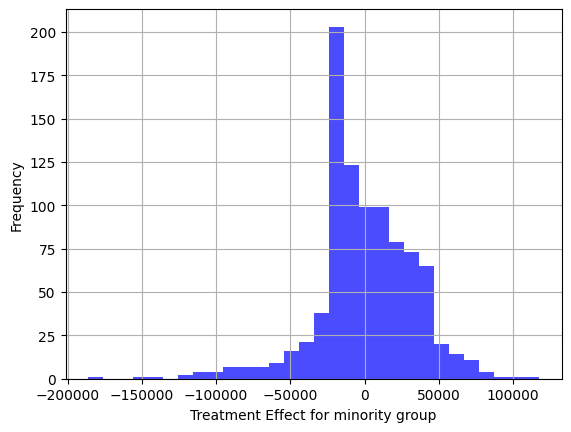

In [29]:
plt.hist(scores_min, bins=30, color='blue', alpha=0.7)
plt.xlabel('Treatment Effect for minority group')
plt.ylabel('Frequency')
plt.grid(True)
%matplotlib inline
plt.show()

In [30]:
def get_AUTOC(score, cate_pred):
    # cate_pred = cate_pred.flatten()
    # score_ranked = score[np.argsort(-cate_pred)]
    # AUTOC = 0
    # ATE = np.mean(score_ranked)
    # for i in range(len(score_ranked)): 
    #     AUTOC += (1/len(score_ranked)) * (np.mean(score_ranked[:i+1]) - ATE)
    # return AUTOC
    cate_pred = cate_pred.flatten()
    score_ranked = score[np.argsort(-cate_pred)].flatten()
    F_s = np.array(range(1,len(score_ranked)+1)) / len(score_ranked)
    return np.mean((-np.log(F_s) - 1) * score_ranked)

In [31]:
model = causalForest_estimator(X_train, W_train, Y_train, A_train, weight_minority=1.0)

In [32]:
model_test = causalForest_estimator(X_test, W_test, Y_test, A_test, weight_minority=1.0)

In [33]:
CATE_pred = grf.predict_causal_forest(model, X_test)

In [34]:
rate = grf.rank_average_treatment_effect(model_test, CATE_pred)

In [35]:
rate[0]

array([40.36851769])

In [36]:
CATE_pred = np.array(CATE_pred).flatten()
get_AUTOC(scores, CATE_pred)

-56.966909063674045

In [37]:
get_AUTOC(scores, scores)

27632.070170585997

In [38]:
def plot_TOC(score, cate_pred, save = False, name = ""):
    score_ranked = score[np.argsort(-cate_pred)]
    TOC = []
    treated_fraction = []
    for i in range(100):
        treated_fraction.append((i+1)/100)
        TOC.append(np.mean(score_ranked[:int(len(score_ranked) * (i+1) / 100)]) - np.mean(score_ranked))
    plt.plot(treated_fraction, TOC)
    plt.xlabel('Treated Fraction')
    plt.ylabel('TOC')
    plt.title('TOC: By decreasing CATE estimates')
    
    plt.tight_layout()
    if save:
        plt.savefig(name, dpi=200)
    plt.show()

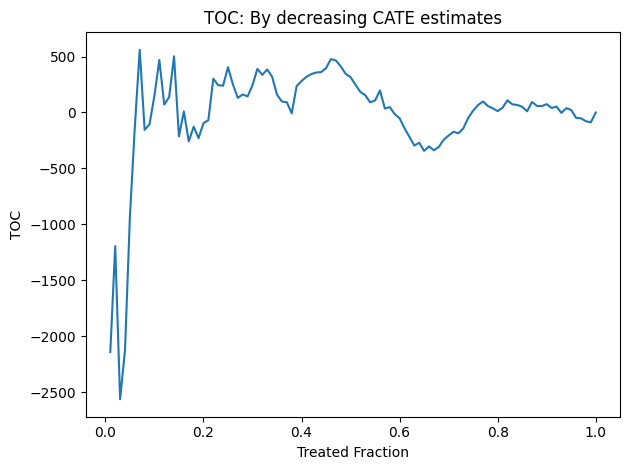

In [39]:
plot_TOC(scores, CATE_pred)

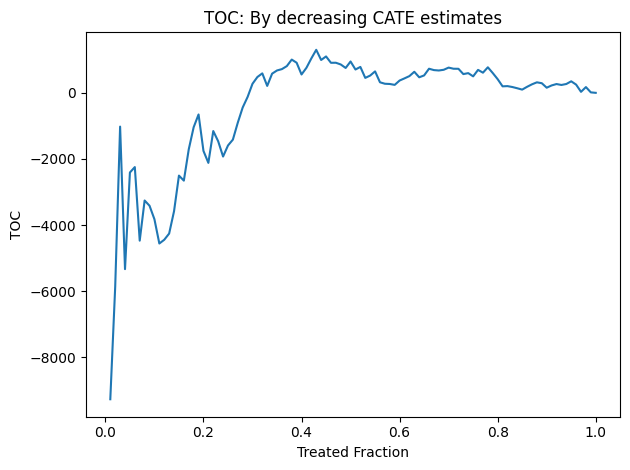

In [40]:
plot_TOC(scores[np.where(A_test[:,0] == 1)[0]], CATE_pred[np.where(A_test[:,0] == 1)[0]])

In [41]:
def get_RATE(X_train, Y_train, W_train, A_train, X_test, A_test, scores, weight_minority=1.0, num_trees=2000, method="AUTOC"):
    RATES_min = []
    RATES_maj = []
    
    for i in range(50): # used to be 10
        model = causalForest_estimator(X_train, W_train, Y_train, A_train, weight_minority=weight_minority, num_trees=num_trees)
        scores_min = scores[np.where(A_test[:,0] == 1)[0]]
        scores_maj = scores[np.where(A_test[:,0] == 0)[0]]
        
        CATE_pred = grf.predict_causal_forest(model, X_test)
        CATE_pred = np.array(CATE_pred).flatten()
        CATE_pred_min = CATE_pred[np.where(A_test[:,0] == 1)[0]]
        CATE_pred_maj = CATE_pred[np.where(A_test[:,0] == 0)[0]]

        if method == "AUTOC":
            RATES_min.append(get_AUTOC(scores_min, CATE_pred_min))
            RATES_maj.append(get_AUTOC(scores_maj, CATE_pred_maj))
        else:
            print("QINI not implemented yet")
    return np.mean(RATES_min), np.std(RATES_min), np.mean(RATES_maj), np.std(RATES_maj)

In [42]:
get_RATE(X_train, Y_train, W_train, A_train, X_test, A_test, scores, method="AUTOC")

(-676.8522149474917, 97.72773448707375, 83.86145226108142, 52.27822065375354)

In [43]:
mu_list = []
RATE_minority_test_list, RATE_majority_test_list = [], []
start_time = time.time()
for i in range(4, 145): # 49
    # mu in [1,36]
    # mu in [1,12]
    mu_list.append(i/4)
    RATE_min, _, RATE_maj, _ = get_RATE(X_train, Y_train, W_train, A_train, X_test, A_test, scores, weight_minority=i/4, num_trees=200, method="AUTOC")
    RATE_minority_test_list.append(RATE_min)
    RATE_majority_test_list.append(RATE_maj)
print("--- %s seconds ---" % (time.time() - start_time))
# takes 33 minutes (with 10 repeats)

--- 4414.690624952316 seconds ---


In [44]:
def plot_RATE(mu_list, test_min, test_maj, name=None, custom_xticks=None, custom_yticks=None, min_MSE=0, max_MSE=1.5, optimal_points = None):
    plt.figure(figsize=(5,5))
    plt.subplot(1, 1, 1)
    
    # smaller circles indicate smaller weight
    scatter_1 = plt.scatter(test_min, test_maj, c=mu_list, cmap='viridis', s=np.array(mu_list)/2+3)
    if optimal_points is not None:
        plt.scatter(optimal_points[2], optimal_points[3], color='red', marker='o', s=15, label = "Optimal MSEs")
    plt.colorbar(scatter_1, label='weight on minority group')
    # plt.plot(np.linspace(min_MSE, max_MSE, 100), np.linspace(min_MSE, max_MSE, 100), linestyle='--', color='grey')
    plt.xlabel('AUTOC RATE metric on minority group')
    plt.ylabel('AUTOC RATE metric on majority group')
    plt.axis('equal')
    plt.title('AUTOC RATE on majority group vs. minority group')
    if optimal_points is not None:
        plt.legend()
    
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, dpi=200)
    plt.show()

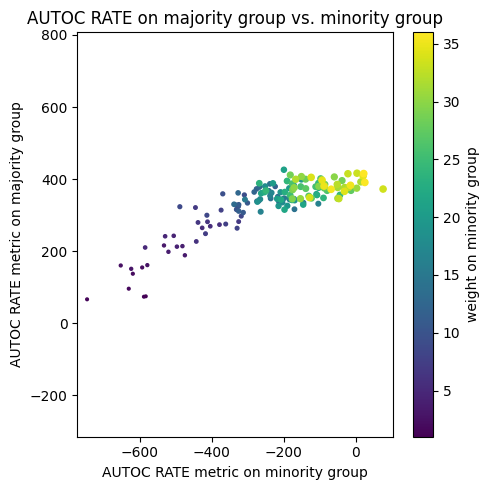

In [45]:
plot_RATE(mu_list, RATE_minority_test_list, RATE_majority_test_list, 'JTPA_earn_CausallForest_reweight_AUROC_RATEViz.png')

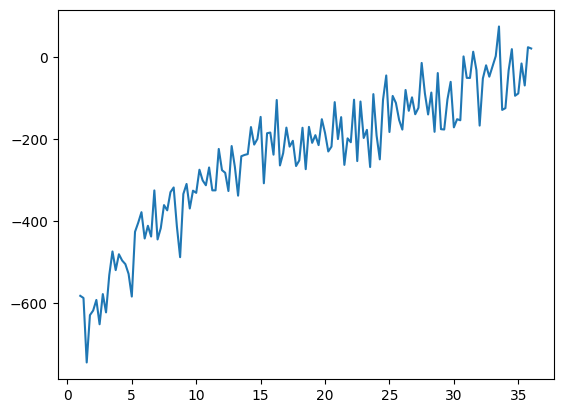

In [46]:
plt.plot(mu_list,RATE_minority_test_list)

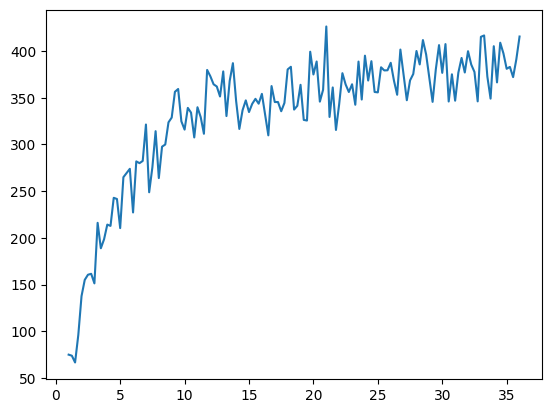

In [47]:
plt.plot(mu_list,RATE_majority_test_list)

In [48]:
# save df_train for synthetic data generation
df_train.to_csv("JTPA_earn_train.csv", index=False)

## Synthetic data augmentation

In [52]:
df_generated = pd.read_csv("JTPA_earn_elder_generated.csv")

In [53]:
df_generated["age"] = round(df_generated["age"])

In [54]:
df_generated["elder"] = df_generated["age"].apply(lambda x: 1 if x>=40 else 0)

In [55]:
df_generated_minority = df_generated[df_generated["elder"] == 1]

In [56]:
df_generated_minority

,total_earn,age,hsged,white,black,hispanic,native,asian,children,married,male,elder,treatment,y_cf
0,46398.6200,43.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,18027.7030
1,0.0000,40.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,9507.8400
2,22573.2900,54.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1,1,13862.1820
3,66449.5500,57.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1,1,2309.5762
4,24443.7340,44.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999987,15524.6470,45.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,2052.8008
999990,8710.5210,53.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,0.0000
999996,1167.2373,51.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0.0000
999997,0.0000,58.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,16684.9570


In [57]:
len(df_train[df_train["elder"] == 1]), len(df_train[df_train["elder"] == 0])

(971, 5628)

In [58]:
def get_RATE(X_train, Y_train, W_train, A_train, X_test, A_test, scores, weight_minority=1.0, num_trees=2000, method="AUTOC"):
    RATES_min = []
    RATES_maj = [] 
    
    for i in range(5): # should be 5 here
        model = causalForest_estimator(X_train, W_train, Y_train, A_train, weight_minority=weight_minority, num_trees=num_trees)
        scores_min = scores[np.where(A_test[:,0] == 1)[0]]
        scores_maj = scores[np.where(A_test[:,0] == 0)[0]]
        
        CATE_pred = grf.predict_causal_forest(model, X_test)
        CATE_pred = np.array(CATE_pred).flatten()
        CATE_pred_min = CATE_pred[np.where(A_test[:,0] == 1)[0]]
        CATE_pred_maj = CATE_pred[np.where(A_test[:,0] == 0)[0]]

        if method == "AUTOC":
            RATES_min.append(get_AUTOC(scores_min, CATE_pred_min))
            RATES_maj.append(get_AUTOC(scores_maj, CATE_pred_maj))
        else:
            print("QINI not implemented yet")
    return np.mean(RATES_min), np.std(RATES_min), np.mean(RATES_maj), np.std(RATES_maj)

In [59]:
ratio_list = []
RATE_minority_test_list, RATE_majority_test_list = [], []
start_time = time.time()

for i in range(40): # 40
    # everytime add 200 more minority data point to training set
    ratio_list.append((len(df_train[df_train["elder"] == 1])+i*200)/len(df_train[df_train["elder"] == 0]))
    min_temp = []
    maj_temp = []
    for j in range(10): # should be 10 here
        if i != 0:
            df_sampled = df_generated_minority.sample(200*i)
            X = np.vstack((X_train,df_sampled[["age", "hsged", "white", "black", "hispanic", "native", "asian", "children", "married", "male"]].values))
            W = np.vstack((W_train,df_sampled[["treatment"]].values))
            Y = np.vstack((Y_train,df_sampled[["total_earn"]].values))
            A = np.vstack((A_train,df_sampled[["elder"]].values))
        else:
            X = X_train
            W = W_train
            Y = Y_train
            A = A_train
        RATE_min, _, RATE_maj, _ = get_RATE(X, Y, W, A, X_test, A_test, scores, num_trees=200, method="AUTOC")
        min_temp.append(RATE_min)
        maj_temp.append(RATE_maj)
    RATE_minority_test_list.append(np.mean(min_temp))
    RATE_majority_test_list.append(np.mean(maj_temp))

print("--- %s seconds ---" % (time.time() - start_time))
# it's gonna take 3 hours?


--- 1782.393117904663 seconds ---


In [60]:
def plot_RATE(mu_list, test_min, test_maj, name=None, custom_xticks=None, custom_yticks=None, min_MSE=0, max_MSE=1.5, optimal_points = None):
    plt.figure(figsize=(5,5))
    plt.subplot(1, 1, 1)
    
    # smaller circles indicate smaller weight
    scatter_1 = plt.scatter(test_min, test_maj, c=mu_list, cmap='viridis', s=(np.array(mu_list)*8+3))
    if optimal_points is not None:
        plt.scatter(optimal_points[2], optimal_points[3], color='red', marker='o', s=15, label = "Optimal MSEs")
    plt.colorbar(scatter_1, label='minority group size / majority group size')
    # plt.plot(np.linspace(min_MSE, max_MSE, 100), np.linspace(min_MSE, max_MSE, 100), linestyle='--', color='grey')
    plt.xlabel('AUTOC RATE metric on minority group')
    plt.ylabel('AUTOC RATE metric on majority group')
    plt.axis('equal')
    plt.title('AUTOC RATE on majority group vs. minority group')
    if optimal_points is not None:
        plt.legend()
    
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, dpi=200)
    plt.show()

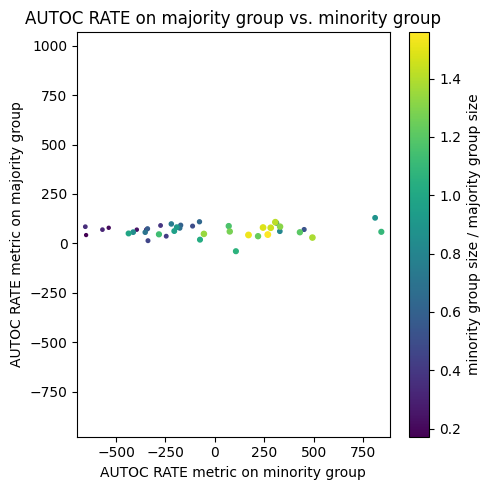

In [61]:
plot_RATE(ratio_list, RATE_minority_test_list, RATE_majority_test_list, 'JTPA_earn_CausallForest_synth_AUROC_RATEViz.png')

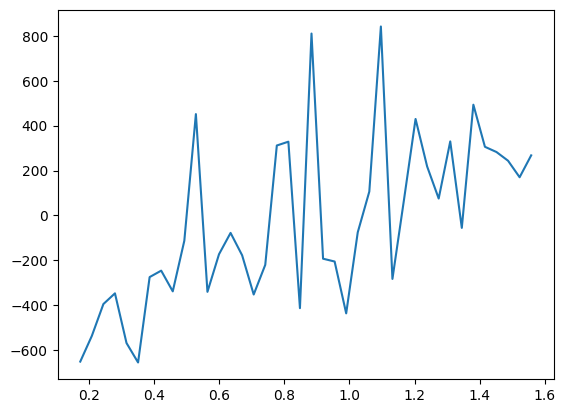

In [62]:
plt.plot(ratio_list,RATE_minority_test_list)

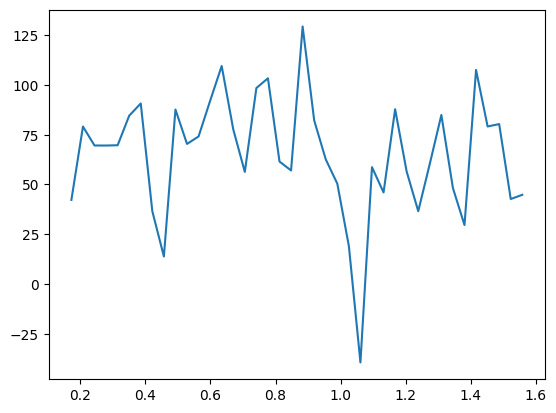

In [63]:
plt.plot(ratio_list,RATE_majority_test_list)

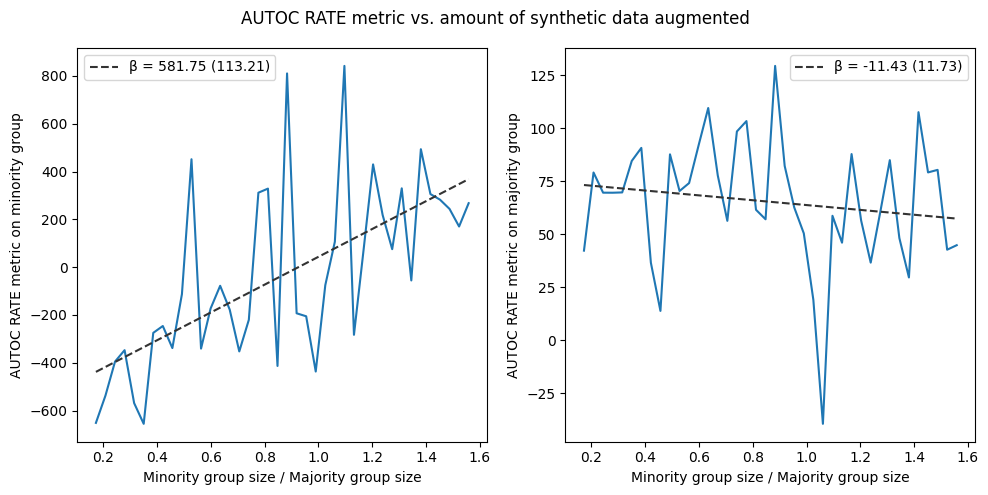

In [64]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(ratio_list, RATE_minority_test_list)

x_first_half, y_first_half = ratio_list, RATE_minority_test_list

# Fitting lines to the first and second halves of the data
coefficients_first_half, cov_first_half = np.polyfit(x_first_half, y_first_half, 1, cov=True)

# Generating the line equations
line_first_half = np.poly1d(coefficients_first_half)

# Extracting standard deviation from the covariance matrix
std_dev_first_half = np.sqrt(np.diag(cov_first_half))[0]

# Plotting the lines of best fit for the first and second halves
color='#333333'
plt.plot(x_first_half, line_first_half(x_first_half), label=f'β = {coefficients_first_half[0]:.2f} ({std_dev_first_half:.2f})', linestyle = '--', color=color)
# plt.axvline(x=mu_list[idx], color='black', linestyle='-.')

# Adding text above each line with the beta coefficient
# plt.text((1+1+idx / 4)/2, line_first_half((1+1+idx / 4)/2)-10, f'slope: {coefficients_first_half[0]:.2f} ({std_dev_first_half:.2f})', fontsize=10, ha='center', color=color)
# plt.text((12+1+idx / 4)/2, line_second_half((12+1+idx / 4)/2)-10, f'slope: {coefficients_second_half[0]:.2f} ({std_dev_second_half:.2f})', fontsize=10, ha='center', color=color)

# plt.xticks([1.5,3.0,4.5,6,7.5,9,10.5,12])
plt.legend()
plt.xlabel('Minority group size / Majority group size')
plt.ylabel('AUTOC RATE metric on minority group')

# second plot for majority
plt.subplot(1, 2, 2)
plt.plot(ratio_list, RATE_majority_test_list)

coefficients_line, cov_line = np.polyfit(ratio_list, RATE_majority_test_list, 1, cov=True)

# Generating the line equations
line = np.poly1d(coefficients_line)

# Extracting standard deviation from the covariance matrix
std_dev_line = np.sqrt(np.diag(cov_line))[0]

# Plotting the lines of best fit
plt.plot(ratio_list, line(ratio_list), label=f'β = {coefficients_line[0]:.2f} ({std_dev_line :.2f})', linestyle = '--', color=color)

# plt.xticks([1.5,3.0,4.5,6,7.5,9,10.5,12])
plt.legend()
plt.xlabel('Minority group size / Majority group size')
plt.ylabel('AUTOC RATE metric on majority group')

fig.suptitle('AUTOC RATE metric vs. amount of synthetic data augmented') #  fontsize=16, y=1.05
plt.tight_layout()
plt.savefig("AUTOC_synthratio_best_fit", dpi=200)
plt.show()